
## Chap 06. Temporal Difference (TD)

---- 

- conda env : [ai_robotics](../README.md#setup-a-conda-environment)

---







- Policy Evaluation for the case of Model Free + Continous Task
    - TD = Monte Carol Method + Dynamic Programming
    - TD (Temporal Difference) : Model Free + Continous Task


### Chap. 6.1 TD Equation

- reward function:
    - $G_t = R_t + \gamma G_{t+1}$
- value function:
    - $v_{\pi}(s) = E_{\pi}(R_t + \gamma G_{t+1}|S_t = s]$
    - $v_{\pi}(s) = \sum\limits_{a, s'} \pi(a|s)p(s'|s,a)\bigg( r(s,a,s') + \gamma v_{\pi}(s)\bigg)$

- MC : <font color="red"> $$V'_{\pi}(s) = V_{\pi}(s) + \alpha \big( G_{t} - V_{\pi}(s)\big)$$ </font>
- DP : $V'_{\pi}(s) = \sum\limits_{a, s'} \pi(a|s)p(s'|s,a)\bigg( r(s,a,s') + \gamma V_{\pi}(s)\bigg)$
- TD: <font color="red"> $$V'_{\pi}(S_t) = V_{\pi}(s) + \alpha \big(  R_t + \gamma V_{\pi}(S_{t+1}) - V_{\pi}(S_t)\big)$$ </font>



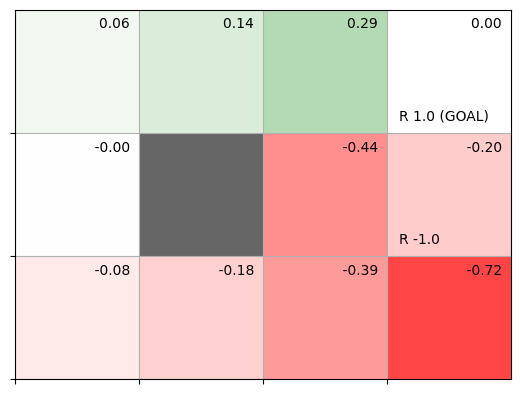

In [1]:
# @title Chap 6.1.3 TD implmentation
from common.gridworld import GridWorld
from collections import defaultdict
import numpy as np

def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes)== 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))
    selected = np.random.choice(idxes)
    return selected


def greedy_probe(Q, state, epsilon = 0, action_size = 4):
    aq = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(aq)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)} #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4

        random_action = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_action)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]
        target = reward + self.gamma * next_V

        self.V[state] += (target - self.V[state]) * self.alpha

env = GridWorld()
agent = TdAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.eval(state, reward, next_state, done)

        if done:
            break
        state = next_state

env.render_v(agent.V)



-----

### Chap 6.2 SARSA (Policy Control)

- On-Policy SARSA(State-Action-Reward-State-Action)
- $\mu(s) = \underset{a}{\operatorname{argmax}}Q_{\pi}(s,a)$
- TD-Plicy Evaluation: 
    - <font color="red"> $$ V'_{\pi}(S_t) = V_{\pi}(S_t) + \alpha \big(  R_t + \gamma V_{\pi}(S_{t+1}) - V_{\pi}(S_t)\big) $$ </font>
- TD-Plicy Control: 
    - <font color="red"> $$ Q'_{\pi}(S_t, A_t) = Q_{\pi}(S_t) + \alpha \big(  R_t + \gamma Q_{\pi}(S_{t+1}, A_{t+1}) - Q_{\pi}(S_t, A_t)\big) $$
</font>
- TD: On-Policy
    $$\begin{equation*}\pi'(a|S_t)= \begin{cases}
    \underset{a}{\operatorname{argmax}}Q_{\pi}(S_t, a) & (1- ϵ) \\
    random-action & ϵ
    \end{cases} \end{equation*} $$

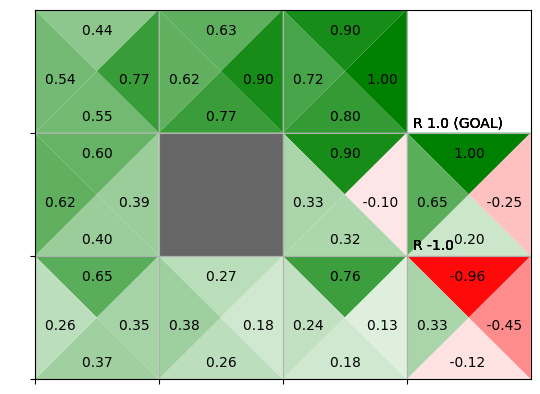

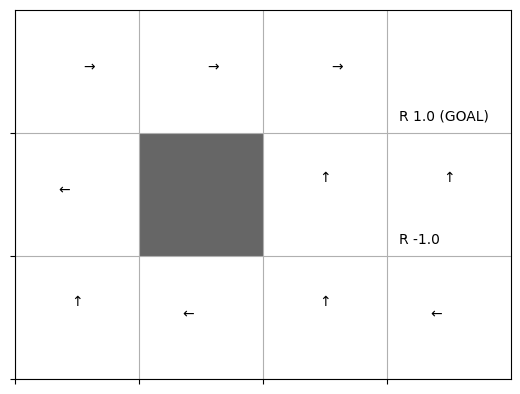

In [2]:
# @title Chap 6.2.2 SARSA implmentation
from common.gridworld import GridWorld
# from common.utils import greedy_probs
from collections import defaultdict, deque
import numpy as np

def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes)== 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))
    selected = np.random.choice(idxes)
    return selected


def greedy_probs(Q, state, epsilon = 0, action_size = 4):
    aq = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(aq)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)} #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        next_q = 0 if done else self.Q[next_state, next_action]

        target = reward + self.gamma * next_q
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

env = GridWorld()
agent = SarsaAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)



------

### Chap 6.3 SARSA-Off Policy

- TD-Plicy Control: 
- <font color="red"> $$Q'_{\pi}(S_t, A_t) = Q_{\pi}(S_t) + \alpha \big(  R_t + \gamma Q_{\pi}(S_{t+1}, A_{t+1}) - Q_{\pi}(S_t, A_t)\big)$$
</font>

Action Sampleing - 1
- Sampling : $A_{t+1} ← {\pi}$
- $Q'_{\pi}(S_t, A_t) = Q_{\pi}(S_t, A_t) + \alpha \big(  R_t + \gamma Q_{\pi}(S_{t+1}, A_{t+1}) - Q_{\pi}(S_t, A_t)\big)$

Action Sampleing - 2
- Sampling : $A_{t+1} ← b$
- $\rho = \frac{\pi(A_{t+1}|S_{t+1})}{b(A_{t+1}|S_{t+1})}$
- $Q'_{\pi}(S_t, A_t) = Q_{\pi}(S_t, A_t) + \alpha \bigg( ρ\big(R_t + \gamma Q_{\pi}(S_{t+1}, A_{t+1}) \big) - Q_{\pi}(S_t, A_t)\bigg)$


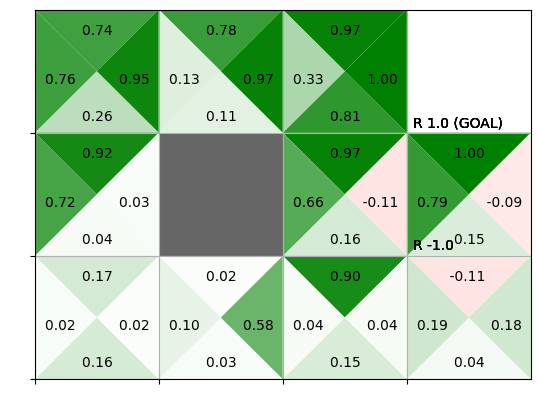

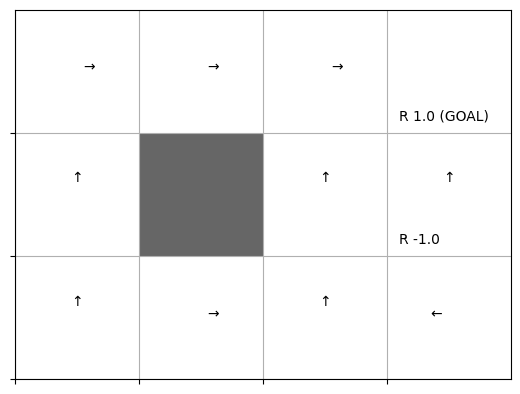

In [3]:
# @title Chap 6.3.2 Off-Policy SARSA Implementation
from common.gridworld import GridWorld
from collections import defaultdict
import numpy as np

def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes)== 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))
    selected = np.random.choice(idxes)
    return selected


def greedy_probs(Q, state, epsilon = 0, action_size = 4):
    aq = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(aq)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)} #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        if done:
            next_q = 0
            rho = 1
        else:
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]

        # On-Policy
        # target = reward + self.gamma * next_q
        # self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        # self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

        # Off-Policy
        target = rho*(reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = SarsaOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)


-----

### <font color="red"> **Chap 6.4 Q-Learning** </font>

- Q-Learning
    - TD
    - Off-policy
    - No important sampling

> - **Bellman equation → SARSA**
> - **Optimal Bellman equation → Q-Learning**

#### Chap 6.4.1 Bellman equation and SARSA $ $

- Bellman equation
    - $q_{\pi}(s,a) = \sum\limits_{s'} p(s'|s,a)\bigg( r(s,a,s') + \gamma \sum\limits_{a'} \pi(a'|s')q_{\pi}(s', a')\bigg)$
    - The above equation considers the all state transition ($p(s'|s,a)$) and all actions from the policy ($\pi$)

- SARSA
    - This approach does not consider all state transition and all actions.
    - Only counts the sampled data.

    

#### Chap 6.4.2 Optimal Bellman Equation and Q-Learning $ $

- Check <font color="red">Chap 4.5 Value-Iteration</font>


**Optimal Bellman equation**
- $q_{*}(s,a) = \sum\limits_{s'} p(s'|s,a)\bigg( r(s,a,s') + \gamma \underset{a'}{\operatorname{max}}q_{*}(s', a')\bigg)$

**Q-Learning**
- $Q'_{\pi}(S_t, A_t) = Q_{\pi}(S_t, A_t) + \alpha \big(  R_t + \gamma \underset{a}{\operatorname{max}}Q(S_{t+1}, a) - Q_{\pi}(S_t, A_t)\big)$




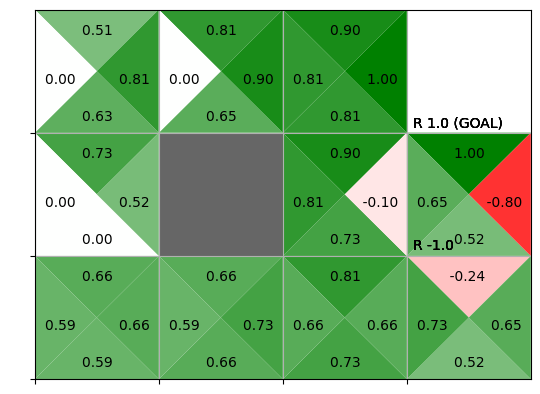

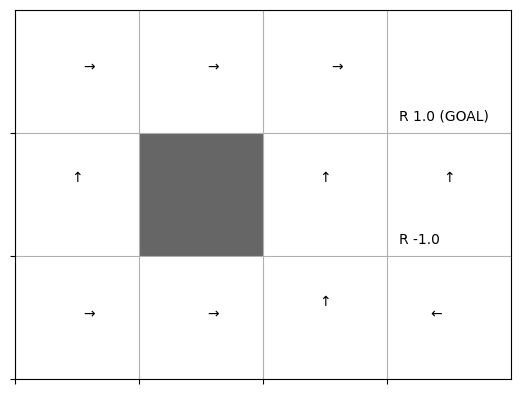

In [4]:
# @title Chap 6.4.3 Q-Learning Implementation
from common.gridworld import GridWorld
from collections import defaultdict
import numpy as np

def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes)== 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))
    selected = np.random.choice(idxes)
    return selected


def greedy_probs(Q, state, epsilon = 0, action_size = 4):
    aq = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(aq)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)} #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = QLearningAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)

        if done:
            break
        state = next_state

env.render_q(agent.Q)


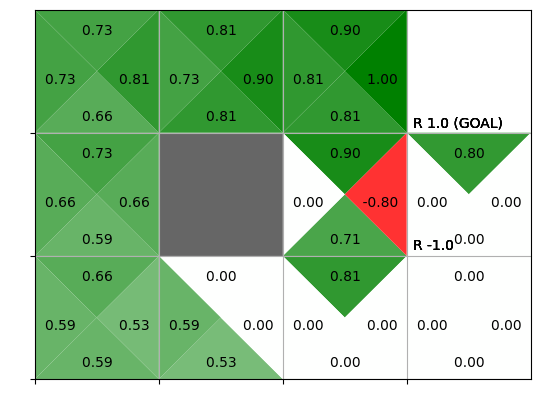

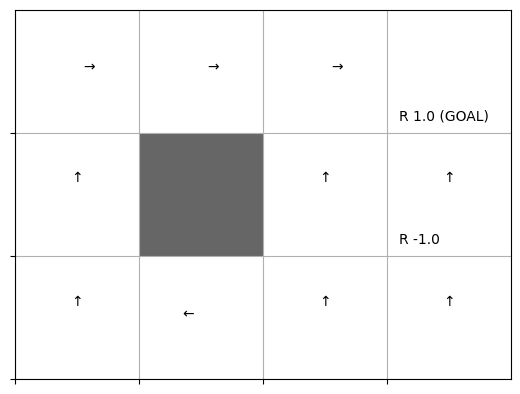

In [5]:
# @title Chap. 6.5.2. Q-Learning Sampling version
from common.gridworld import GridWorld
from collections import defaultdict
import numpy as np


class QLearningAgentSample:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        # self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha



env = GridWorld()
agent = QLearningAgentSample()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)

        if done:
            break
        state = next_state

env.render_q(agent.Q)

----
----
### Reference : On-Ploicy vs Off-Policy

Off-policy and On-policy are two types of learning approaches in Reinforcement Learning (RL) that differ in how they update policies based on collected experiences.

1. **On-Policy Learning**
- The agent learns from the same policy it is currently following.
- The policy used to collect experience is the same as the one being improved.
- Example: SARSA (State-Action-Reward-State-Action)
- Pros:
    - More stable training.
    - Learns directly from its own behavior, making it suitable for environments where exploration-exploitation balance is critical.
- Cons:
    - Less sample-efficient since it discards past data if the policy changes.
2. **Off-Policy Learning**
- The agent learns from a different policy than the one used to generate data.
- The policy being updated can be different from the one used to explore the environment.
- Example: Q-learning, Deep Q-Networks (DQN)
- Pros:
    - More sample-efficient since it can use past experiences (e.g., experience replay).
    - Allows learning from demonstrations or previously collected data.
- Cons:
    - Can be unstable or less robust due to the divergence between the behavior and target policies.
- Key Difference:

|Feature	|On-Policy	|Off-Policy|
| ----      | ----      | ----     |
|Policy used for training	|Same as data collection	|Different from data collection|
|Stability	|More stable	|Can be unstable|
|Sample efficiency	|Less efficient	|More efficient|
|Example algorithms	|SARSA, Policy Gradient methods	|Q-Learning, DQN|

In summary, On-Policy learning is more stable but slower, while Off-Policy learning is more efficient but may require additional techniques to ensure stability.